In [37]:
!pip install pysheds rasterio matplotlib numpy geopandas
!sudo apt-get update
!sudo apt-get install gdal-bin libgdal-dev
!pip install python-gdal

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

/usr/local/lib/python3.11/dist-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/usr/local/lib/python3.11/dist-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


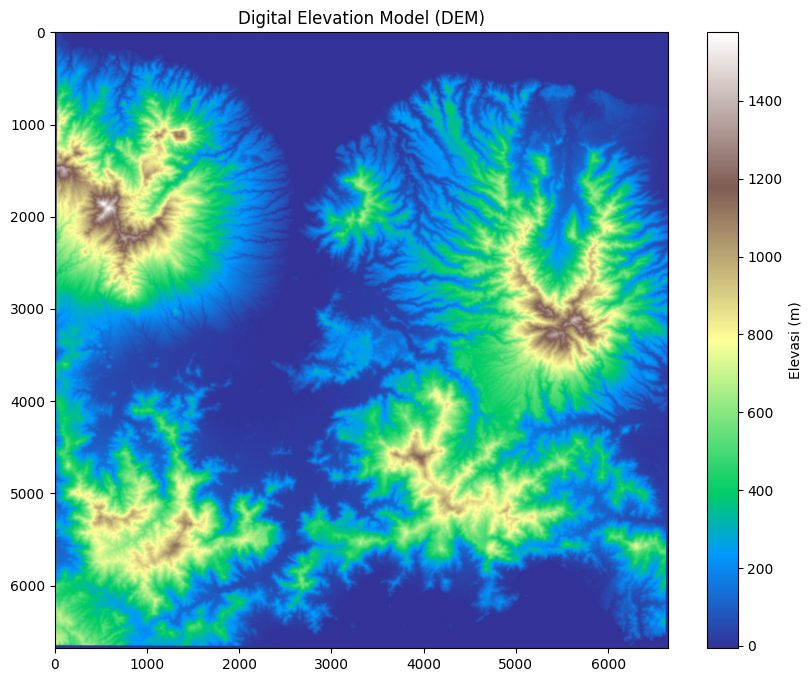

In [38]:
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import numpy as np
# Baca file DEM (.tif)
grid = Grid.from_raster('/DEMNAS_Gabung_Projected.tif')
dem = grid.read_raster('/DEMNAS_Gabung_Projected.tif')
# Visualisasi DEM
plt.figure(figsize=(10, 8))
plt.imshow(dem, cmap='terrain')
plt.colorbar(label='Elevasi (m)')
plt.title('Digital Elevation Model (DEM)')
plt.show()

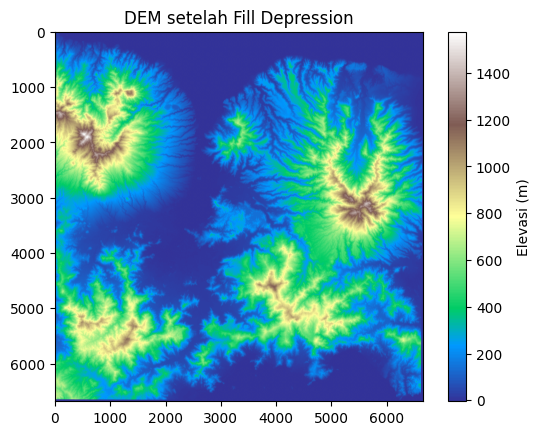

In [39]:
# Isi depresi pada DEM
dem_filled = grid.fill_depressions(dem)
# Visualisasi hasil pengisian
plt.imshow(dem_filled, cmap='terrain')
plt.colorbar(label='Elevasi (m)')
plt.title('DEM setelah Fill Depression')
plt.show()

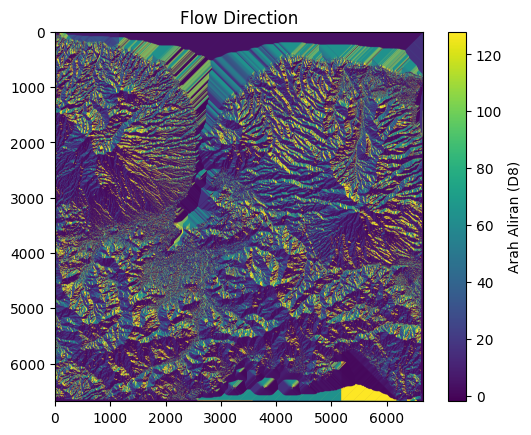

In [40]:
# Hitung arah aliran (flow direction)
fdir = grid.resolve_flats(dem_filled)
flow_dir = grid.flowdir(fdir, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))
# Visualisasi arah aliran
plt.imshow(flow_dir, cmap='viridis')
plt.colorbar(label='Arah Aliran (D8)')
plt.title('Flow Direction')
plt.show()


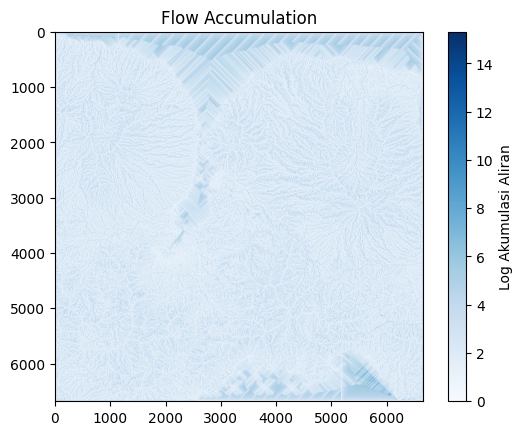

In [41]:
# Hitung akumulasi aliran
acc = grid.accumulation(flow_dir)
# Visualisasi akumulasi aliran (log-scale untuk jelasnya)
plt.imshow(np.log(acc + 1), cmap='Blues')
plt.colorbar(label='Log Akumulasi Aliran')
plt.title('Flow Accumulation')
plt.show()

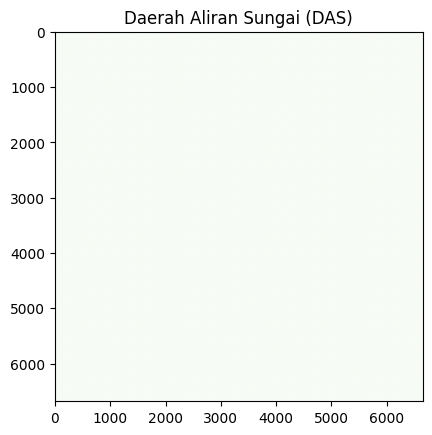

In [42]:
# Tentukan koordinat outlet (contoh: x=500, y=600)
x, y = 118.718653, -8.441884
# Ekstrak DAS berdasarkan aliran menuju outlet
catchment = grid.catchment(x=x, y=y, fdir=flow_dir, xytype='coords')
# Visualisasi DAS
plt.imshow(catchment, cmap='Greens')
plt.title('Daerah Aliran Sungai (DAS)')
plt.show()

In [43]:
import geopandas as gpd
import numpy as np
from shapely.geometry import shape # Import shape from shapely.geometry
# Konversi DAS ke poligon dan simpan sebagai Shapefile
# Convert the boolean catchment array to a supported dtype (e.g., uint8)
catchment_uint8 = catchment.astype(np.uint8)
shapes = grid.polygonize(catchment_uint8)
# Extract geometries from the iterator and convert to shapely objects
geometries = [shape(geom) for geom, value in shapes] # Convert to shapely geometry
gdf = gpd.GeoDataFrame({'geometry': geometries}, crs="EPSG:4326")
# Sesuaikan CRS
gdf.to_file("DAS.shp")

In [44]:
# Hitung luas DAS (dalam piksel)
luas_piksel = np.sum(catchment)
print(f"Luas DAS: {luas_piksel} piksel")
# Hitung kemiringan rata-rata
dx, dy = np.gradient(dem_filled)
slope = np.sqrt(dx**2 + dy**2)
slope_das = np.mean(slope[catchment == 1])
print(f"Kemiringan rata-rata DAS: {slope_das:.2f} radian")


Luas DAS: 0 piksel
Kemiringan rata-rata DAS: nan radian


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3594: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [45]:
def scs_runoff(P, CN):
    S = (25400 / CN) - 254 # Maximum soil retention (mm)
    if P > 0.2 * S:
        Q = (P - 0.2 * S)**2 / (P + 0.8 * S)
    else:
        Q = 0
    return Q
# Contoh: Curah hujan 50 mm, CN = 70 (tanah pertanian)
P = 50 # mm
CN = 70
Q = scs_runoff(P, CN)
print(f"Runoff: {Q:.2f} mm")

Runoff: 5.81 mm


In [46]:
def rational_method(C, I, A):
 Q = (C * I * A) / 3.6 # Q dalam m³/detik
 return Q
# Contoh: C=0.5, I=30 mm/jam, A=10 km²
Q_debit = rational_method(C=0.5, I=30, A=10)
print(f"Debit: {Q_debit:.2f} m³/detik")

Debit: 41.67 m³/detik


In [47]:
def muskingum_routing(I1, I2, Q1, K, x, dt):
 C1 = (dt - 2*K*x) / (2*K*(1-x) + dt)
 C2 = (dt + 2*K*x) / (2*K*(1-x) + dt)
 C3 = (2*K*(1-x) - dt) / (2*K*(1-x) + dt)
 Q2 = C1*I2 + C2*I1 + C3*Q1
 return Q2
# Contoh:
K = 2 # jam
x = 0.2
dt = 1 # jam
Q1 = 10 # m³/detik (debit awal)
I1, I2 = 50, 60 # m³/detik (inflow)
Q2 = muskingum_routing(I1, I2, Q1, K, x, dt)
print(f"Debit setelah routing: {Q2:.2f} m³/detik")

Debit setelah routing: 29.52 m³/detik


In [48]:
# Misal 70% hutan (CN=60), 30% pertanian (CN=70)
CN = 0.7*60 + 0.3*70

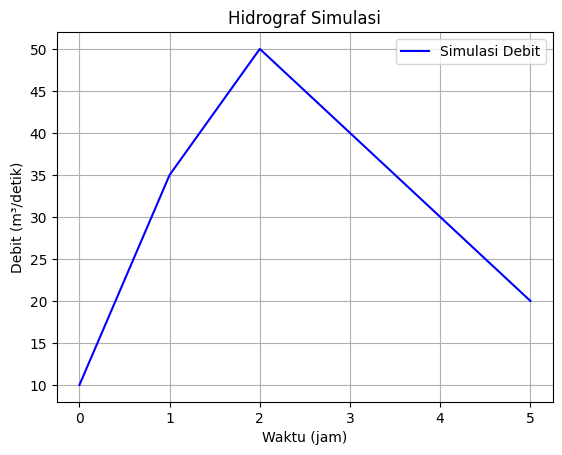

In [49]:
import matplotlib.pyplot as plt
# Contoh hidrograf hasil simulasi
time = [0, 1, 2, 3, 4, 5] # jam
debit = [10, 35, 50, 40, 30, 20] # m³/detik
plt.plot(time, debit, 'b-', label='Simulasi Debit')
plt.xlabel('Waktu (jam)')
plt.ylabel('Debit (m³/detik)')
plt.title('Hidrograf Simulasi')
plt.legend()
plt.grid()
plt.show()